### Importing necessary libraries

In [56]:
import math
import os
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader

### Creating a GPU device if available

In [57]:
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True


### CNN Hyperparameters

In [58]:
image_base_size = 256
num_epochs = 10
batch_size = 10
learning_rate = 0.001

### Creating the dataset and loading in the monkeys

In [59]:


composed = transforms.Compose([
    transforms.ConvertImageDtype(torch.float32),
    transforms.Resize([image_base_size, image_base_size])  # Square images idea for CNN

])

class MonkeyDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform):
        self.annotations_file = annotations_file
        self.img_dir = img_dir
        self.img_labels = pd.read_csv(annotations_file)
        self.transform = transform
        self.number_samples = 0

        # Adding all monkeys to a list
        self.monkeys = []
        for dirname, _, filenames in os.walk(self.img_dir):
            for filename in filenames:
                self.number_samples += 1
                self.monkeys.append((
                    os.path.join(dirname, filename),
                    filename
                ))

    def __getitem__(self, index):
        monkey_path, monkey_filename = self.monkeys[index]

        # Read monkey image from directory name
        monkey = read_image(monkey_path)

        # Get monkey label from filename
        label = int(monkey_filename[1:2])  # Works since n0 to n9 all 2 characters
        
        # Apply the transforms:
        if self.transform:
            tmonkey = self.transform(monkey)
        
        return tmonkey, label

    def __len__(self):
        # This will allow len()
        return self.number_samples
    
    def get_label_map(self):
        print({i.strip():j.strip() for i, j in zip(self.img_labels.iloc[:, 0], self.img_labels.iloc[:, 2])})

    def get_label_map2(self):
        print({i.strip():j for i, j in zip(self.img_labels.iloc[:, 0], range(0, 10))})



# train_data = MonkeyDataset()
training_data = MonkeyDataset(
    annotations_file = "./kaggle/input/10-monkey-species/monkey_labels.txt",
    img_dir = "./kaggle/input/10-monkey-species/training/training",
    transform = composed
)
validation_data = MonkeyDataset(
    annotations_file = "./kaggle/input/10-monkey-species/monkey_labels.txt",
    img_dir = "./kaggle/input/10-monkey-species/validation/validation",
    transform = composed
)

label2name = training_data.get_label_map()
label2num = training_data.get_label_map2()
pprint(label2name, label2num)

{'n0': 'mantled_howler', 'n1': 'patas_monkey', 'n2': 'bald_uakari', 'n3': 'japanese_macaque', 'n4': 'pygmy_marmoset', 'n5': 'white_headed_capuchin', 'n6': 'silvery_marmoset', 'n7': 'common_squirrel_monkey', 'n8': 'black_headed_night_monkey', 'n9': 'nilgiri_langur'}
{'n0': 0, 'n1': 1, 'n2': 2, 'n3': 3, 'n4': 4, 'n5': 5, 'n6': 6, 'n7': 7, 'n8': 8, 'n9': 9}
None


### Testing dataloaders and showing example monkey

tensor([[[0.4665, 0.4723, 0.4786,  ..., 0.1654, 0.1788, 0.2261],
         [0.4745, 0.4745, 0.4780,  ..., 0.1685, 0.1816, 0.2257],
         [0.4706, 0.4799, 0.4865,  ..., 0.1716, 0.1945, 0.2378],
         ...,
         [0.7092, 0.6857, 0.6602,  ..., 0.7066, 0.7192, 0.6933],
         [0.7182, 0.6798, 0.6454,  ..., 0.5988, 0.6507, 0.7152],
         [0.6798, 0.6668, 0.6948,  ..., 0.6616, 0.6254, 0.5853]],

        [[0.3803, 0.3900, 0.3962,  ..., 0.0906, 0.1000, 0.1445],
         [0.3882, 0.3922, 0.3957,  ..., 0.0937, 0.1027, 0.1440],
         [0.3843, 0.3975, 0.4042,  ..., 0.0971, 0.1170, 0.1562],
         ...,
         [0.6857, 0.6557, 0.6223,  ..., 0.5883, 0.6051, 0.5812],
         [0.6960, 0.6562, 0.6140,  ..., 0.4773, 0.5292, 0.5950],
         [0.6482, 0.6352, 0.6634,  ..., 0.5364, 0.4918, 0.4468]],

        [[0.2861, 0.2841, 0.2903,  ..., 0.0366, 0.0368, 0.0663],
         [0.2941, 0.2863, 0.2898,  ..., 0.0396, 0.0321, 0.0602],
         [0.2902, 0.2916, 0.2983,  ..., 0.0386, 0.0417, 0.

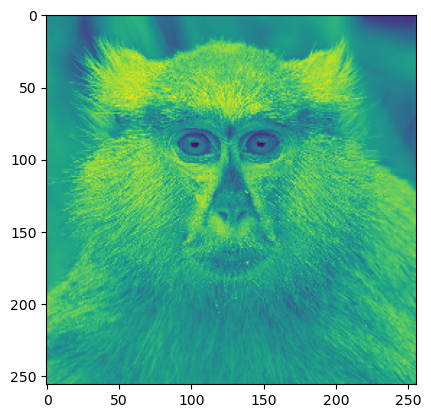

In [60]:
# dataloaders
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(validation_data, batch_size=batch_size, shuffle=True)

# iterating through the dataloader
train_features, train_labels = next(iter(train_dataloader))
print(train_features[0], train_labels)
print(train_features.size())  # batch size, channel count, image size
plt.imshow(train_features[0][0])
plt.show()

### Defining the CNN class

In [61]:
class CNN(nn.Module):
    def __init__(self) -> None:
        # torch.utils.data.Dataset doesn’t define its own __init__ so by calling super().__init__() you are not performing any meaningful actions. In comparison, calling super().__init__() when subclassing torch.nn.Module is required to initialize the internal data structures for storing buffers, modules, etc.
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=3)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=3)
        # self.pool2 = nn.MaxPool2d(kernel_size=3, stride=3)
        self.conv3 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3)
        # self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        # End up with size of 30 for the regular neural network
        self.full_con1 = nn.Linear(8*8*24, 1000)
        self.full_con2 = nn.Linear(1000, 100)
        self.full_con3 = nn.Linear(100, 10)
    
    def forward(self, x):
        # This whole first part is classification learning
        s = self.pool(F.leaky_relu(self.conv1(x)))  # Function takes in a tensor as input
        s = self.pool(F.leaky_relu(self.conv2(s)))
        s = self.pool(F.leaky_relu(self.conv3(s)))

        # Output channels * image width * image height
        s = torch.reshape(s, [-1, 8*8*24])
        s.size()
        # s = 

        # This whole second part is feature learning
        s = F.leaky_relu(self.full_con1(s))
        s = F.leaky_relu(self.full_con2(s))
        s = self.full_con3(s)

        return s

model = CNN().to(device)
print(model)

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1))
  (full_con1): Linear(in_features=1536, out_features=2000, bias=True)
  (full_con2): Linear(in_features=2000, out_features=500, bias=True)
  (full_con3): Linear(in_features=500, out_features=10, bias=True)
)


### Optimization code

In [62]:
# Loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    for iteration, (monkey, label) in enumerate(train_dataloader):
        monkey = monkey.to(device)
        label = label.to(device)
        # print(monkey.size(), label)

        # Forward pass
        # Pass on torch.Size([64, 3, 256, 256])
        pred = model.forward(monkey)
        # pred2 = model(monkey)
        # print(pred == pred2)

        # Clearing out optimizer grad
        optimizer.zero_grad()

        # Calculate loss
        # Target is a value between 0 and C
        # print(label)
        loss = loss_fn(pred, label)

        # Backward pass
        loss.backward()

        # Optimize (step)
        optimizer.step()

        print(f"Epoch:\t{epoch}\tIteration:\t{iteration}\tLoss:\t{loss}")
        

Epoch:	0	Iteration:	0	Loss:	2.32245135307312
Epoch:	0	Iteration:	1	Loss:	2.3153226375579834
Epoch:	0	Iteration:	2	Loss:	2.3129374980926514
Epoch:	0	Iteration:	3	Loss:	2.380495548248291
Epoch:	0	Iteration:	4	Loss:	2.3541760444641113
Epoch:	0	Iteration:	5	Loss:	2.329082489013672
Epoch:	0	Iteration:	6	Loss:	2.2966578006744385
Epoch:	0	Iteration:	7	Loss:	2.280263662338257
Epoch:	0	Iteration:	8	Loss:	2.255837917327881
Epoch:	0	Iteration:	9	Loss:	2.2994163036346436
Epoch:	0	Iteration:	10	Loss:	2.330934762954712
Epoch:	0	Iteration:	11	Loss:	2.3688321113586426
Epoch:	0	Iteration:	12	Loss:	2.230233907699585
Epoch:	0	Iteration:	13	Loss:	2.2706832885742188
Epoch:	0	Iteration:	14	Loss:	2.423919200897217
Epoch:	0	Iteration:	15	Loss:	2.304908037185669
Epoch:	0	Iteration:	16	Loss:	2.3628745079040527
Epoch:	0	Iteration:	17	Loss:	2.278435230255127
Epoch:	0	Iteration:	18	Loss:	2.281216859817505
Epoch:	0	Iteration:	19	Loss:	2.2759337425231934
Epoch:	0	Iteration:	20	Loss:	2.3598763942718506
Epoch:	0	Itera

### Random testing scrips down here

In [ ]:

e = pd.read_csv("./kaggle/input/10-monkey-species/monkey_labels.txt")
e.iloc[:,3]

tf = train_features
# print(tf, type(tf), tf.size())

conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
pool = nn.MaxPool2d(kernel_size=3, stride=3)
conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=3)
# self.pool2 = nn.MaxPool2d(kernel_size=3, stride=3)
conv3 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3)
# self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
# End up with size of 30 for the regular neural network
full_con1 = nn.Linear(8*8*24, 100)
full_con2 = nn.Linear(100, 50)
full_con3 = nn.Linear(50, 10)

# This whole first part is classification learning
s = pool(F.leaky_relu(conv1(tf)))  # Function takes in a tensor as input
print(type(s), s.size())
s = pool(F.leaky_relu(conv2(s)))
print(type(s), s.size())
s = pool(F.leaky_relu(conv3(s)))
print(type(s), s.size())

# Output channels * image width * image height
# s.view(-1, 30*30*24).size()
s = torch.reshape(s, [-1, 8*8*24])
s.size()
# s = 

# This whole second part is feature learning
s = F.leaky_relu(full_con1(s))
print(type(s), s.size())
s = F.leaky_relu(full_con2(s))
print(type(s), s.size())
s = full_con3(s)
print(type(s), s.size())


print(model.base.parameters())
print(model.classifier.parameters())
for p in model.parameters():
    print(p)